In [125]:
from gymnasium.wrappers import TimeLimit
from env_hiv import HIVPatient
import numpy as np
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import os
import joblib
from sklearn.ensemble import ExtraTreesClassifier

import random
import os
import numpy as np
#import torch

from evaluate import evaluate_HIV, evaluate_HIV_population
from train import ProjectAgent  # Replace DummyAgent with your agent implementation

In [126]:
qfunc = joblib.load('./Q_function.joblib')

In [127]:
print(qfunc)

RandomForestRegressor()


In [128]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    #torch.manual_seed(seed)
    #torch.cuda.manual_seed(seed)
    #torch.backends.cudnn.deterministic = True
    #torch.backends.cudnn.benchmark = False
    #torch.cuda.manual_seed_all(seed)

In [129]:
# Initialization of the agent. Replace DummyAgent with your custom agent implementation.
agent = ProjectAgent()
#Print files in the current directory
agent.load()
# Keep the following lines to evaluate your agent unchanged.
score_agent: float = evaluate_HIV(agent=agent, nb_episode=1)
score_agent_dr: float = evaluate_HIV_population(agent=agent, nb_episode=15)
print(f"Score of the agent: {score_agent}")
print(f"Score of the agent with drug resistance: {score_agent_dr}")
with open(file="score.txt", mode="w") as f:
    f.write(f"{score_agent}\n{score_agent_dr}")

FileNotFoundError: [Errno 2] No such file or directory: '.\\src\\Q_function.joblib'

In [130]:


env = TimeLimit(
    env=HIVPatient(domain_randomization=False), max_episode_steps=200
)  # The time wrapper limits the number of steps in an episode at 200.
# Now is the floor is yours to implement the agent and train it.



In [140]:

# You have to implement your own agent.
# Don't modify the methods names and signatures, but you can add methods.
# ENJOY!
class ProjectAgent:

    def __init__(self, env= env, discount_factor=0.6, epsilon=0.15, horizon=1000):
        """
            The agent class that will be used to train the agent using Q-learning algorithm.
            Args:
                - env: gym environment
                - discount_factor: float, the discount factor for the Q-learning algorithm
                - epsilon: float, the epsilon value for the epsilon-greedy policy
                - episodes: int, the number of episodes to train the agent 
                - max_steps: int, the maximum number of steps in an episode
        """
        
        self.env = env
        self.action_space = env.action_space
        self.q_table = RandomForestRegressor(n_estimators=50, min_samples_split=2, max_features=8).fit(np.zeros((1,env.observation_space.shape[0]+1)),np.zeros(1))
        self.observation_space = env.observation_space
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.horizon = horizon

    def act(self, observation, use_random=False):

        if use_random or np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        else:
            Qsa = []
            for a in range(self.env.action_space.n):
                sa = np.append(observation,a).reshape(1,-1)
                Qsa.append(self.q_table.predict(sa))
            return np.argmax(Qsa)
                

    def save(self):
        """
        Saves the agent's current state to a file specified by the path.

        Args:
            - path (str): The file path where the agent's state should be saved.

        """
        joblib.dump(self.q_table, "./Q_function.joblib")


    def load(self):
        """
        Loads the agent's state from a file specified by the path (HARDCODED).
        """
        self.q_table = joblib.load("./Q_function.joblib")
            

    def collect_samples(self, use_random=False):
        ''' 
        Collect samples from the environment using the current policy
        Args:
            - use_random: bool, whether to use random policy or the current policy
        Returns:
            - S: list, the list of states
            - A: list, the list of actions
            - R: list, the list of rewards
            - S2: list, the list of next states
            - D: list, the list of done flags
        '''
        S, A, R, S2, D = [], [], [], [], []
        for _ in tqdm(range(self.horizon), desc="Collecting samples"):
            state, _ = self.env.reset()
            action = self.act(state, use_random)
            next_state, reward, done, trunc , _ = self.env.step(action)
            S.append(state)
            A.append(action)
            R.append(reward)
            S2.append(next_state)
            D.append(done)
            if done or trunc:
                state = self.env.reset()
            else:
                state = next_state
        S = np.array(S)
        A = np.array(A).reshape(-1, 1)
        R = np.array(R)
        S2 = np.array(S2)
        D = np.array(D)
            
        return S, A, R, S2, D
    
    def fqi(self, S, A, R, S2, D, nb_iter):
        ''' 
        Fitted Q-Iteration algorithm
        Args:
            - S: list, the list of states
            - A: list, the list of actions
            - R: list, the list of rewards
            - S2: list, the list of next states
            - D: list, the list of done flags
            - nb_iter: int, the number of iterations
        '''

        nb_samples = S.shape[0]
        Qfunctions = []
        SA = np.append(S,A,axis=1)
        for iter in tqdm(range(nb_iter), desc="Fitted Q-Iteration"):
            if iter==0:
                value=R.copy()
            else:
                Q2 = np.zeros((nb_samples, self.env.action_space.n))
                for a2 in range(self.env.action_space.n):
                    A2 = a2*np.ones((S.shape[0],1))
                    S2A2 = np.append(S2,A2,axis=1)
                    Q2[:,a2] = Qfunctions[-1].predict(S2A2)
                max_Q2 = np.max(Q2,axis=1)
                value = R + self.discount_factor*(1-D)*max_Q2
            Q = RandomForestRegressor(n_estimators=50, min_samples_split=2, max_features=8)
            Q.fit(SA,value)
            Qfunctions.append(Q)
            self.q_table = Qfunctions[-1]

    def train(self):
        '''
        Train the agent using the Fitted Q-Iteration algorithm
        '''

        S, A, R, S2, D = self.collect_samples(use_random=True)
        self.fqi(S, A, R, S2, D, 100)
        for loop in range(10):
            print("loop",loop)
            S1, A1, R1, S21, D1 = self.collect_samples(use_random=False)
            S = np.append(S,S1,axis=0)
            A = np.append(A,A1,axis=0)
            R = np.append(R,R1)
            S2 = np.append(S2,S21,axis=0)
            D = np.append(D,D1)
            self.fqi(S, A, R, S2, D, 100)



        
        
        
        
        


In [141]:
agent = ProjectAgent(env)
agent.train()

Fitted Q-Iteration: 100%|██████████| 100/100 [00:08<00:00, 12.08it/s]


loop 0


Fitted Q-Iteration: 100%|██████████| 100/100 [00:10<00:00,  9.84it/s]


loop 1


Fitted Q-Iteration: 100%|██████████| 100/100 [00:10<00:00,  9.67it/s]


loop 2


Fitted Q-Iteration: 100%|██████████| 100/100 [00:10<00:00,  9.42it/s]


loop 3


Fitted Q-Iteration: 100%|██████████| 100/100 [00:12<00:00,  7.74it/s]


loop 4


Fitted Q-Iteration: 100%|██████████| 100/100 [00:11<00:00,  8.64it/s]


loop 5


Fitted Q-Iteration: 100%|██████████| 100/100 [00:12<00:00,  8.27it/s]


loop 6


Fitted Q-Iteration: 100%|██████████| 100/100 [00:13<00:00,  7.31it/s]


loop 7


Fitted Q-Iteration: 100%|██████████| 100/100 [00:15<00:00,  6.28it/s]


loop 8


Fitted Q-Iteration: 100%|██████████| 100/100 [00:20<00:00,  4.82it/s]


loop 9


Fitted Q-Iteration: 100%|██████████| 100/100 [00:17<00:00,  5.70it/s]


In [142]:
agent.save()

In [143]:
Q_function = agent.q_table


In [144]:
print("Q-function:", Q_function)

Q-function: RandomForestRegressor(max_features=8, n_estimators=50)


In [145]:
# save
joblib.dump(Q_function, "./Q1_function.joblib")

['./Q1_function.joblib']

state: [1.63573e+05 1.19450e+04 5.00000e+00 4.60000e+01 6.39190e+04 2.40000e+01]
action: 0
Q-value: [44020.25]
Q-value: [44020.25]


In [51]:


def collect_samples(env, agent, horizon, disable_tqdm=False, print_done_states=False, random_actions=False):
    '''
     Collects samples from the environment
        Arguments:
        - env: gym environment
        - agent: object, the agent to use to collect samples
        - horizon: int, number of steps to collect
        - disable_tqdm: bool, if True, disables the tqdm progress bar
        - print_done_states: bool, if True, prints when the environment is done
        - random_actions: bool, if True, samples random actions from the environment's action space
        - alpha: float, the probability of sampling a random action
     '''
    
    s, _ = env.reset()
    #dataset = []
    S = []
    A = []
    R = []
    S2 = []
    D = []
    
    for _ in tqdm(range(horizon), disable=disable_tqdm):

        a = agent.act(s, use_random=random_actions)
        s2, r, done, trunc, _ = env.step(a)
        #dataset.append((s,a,r,s2,done,trunc))
        S.append(s)
        A.append(a)
        R.append(r)
        S2.append(s2)
        D.append(done)
        if done or trunc:
            s, _ = env.reset()
            if done and print_done_states:
                print("done!")
        else:
            s = s2
    S = np.array(S)
    A = np.array(A).reshape((-1,1))
    R = np.array(R)
    S2= np.array(S2)
    D = np.array(D)
    return S, A, R, S2, D
        


In [5]:
S, A, R, S2, D = collect_samples(env, 1000, disable_tqdm=False, print_done_states=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [01:25<00:00, 11.65it/s]


In [6]:
print("nb of collected samples:", S.shape[0])
for i in range(3):
    print("sample", i, "\n  state:", S[i], "\n  action:", A[i], "\n  reward:", R[i], "\n  next state:", S2[i], "\n terminal?", D[i])

nb of collected samples: 1000
sample 0 
  state: [1.63573e+05 1.19450e+04 5.00000e+00 4.60000e+01 6.39190e+04 2.40000e+01] 
  action: [0] 
  reward: 17608.1 
  next state: [1.63572059e+05 1.19450569e+04 4.99536372e+00 4.56109782e+01
 6.39192996e+04 2.39127429e+01] 
 terminal? False
sample 1 
  state: [1.63572059e+05 1.19450569e+04 4.99536372e+00 4.56109782e+01
 6.39192996e+04 2.39127429e+01] 
  action: [1] 
  reward: 15720.812904409093 
  next state: [1.84279276e+05 5.05037709e+03 1.54797477e+01 4.26986832e+01
 1.91847138e+04 2.43162780e+01] 
 terminal? False
sample 2 
  state: [1.84279276e+05 5.05037709e+03 1.54797477e+01 4.26986832e+01
 1.91847138e+04 2.43162780e+01] 
  action: [2] 
  reward: 12597.806650144703 
  next state: [2.21460021e+05 6.01562497e+02 6.14848714e+01 2.80034907e+01
 3.47676582e+03 2.82685686e+01] 
 terminal? False


In [15]:

SA = np.append(S,A,axis=1)
value = R.copy()

Q1 = RandomForestRegressor(n_estimators=1000, max_depth=8, random_state=0)
Q1.fit(SA,value)

RandomForestRegressor(max_depth=8, n_estimators=1000, random_state=0)

In [16]:
# compute MSE
print("training MSE:", np.mean((value-Q1.predict(SA))**2))

training MSE: 1208140.7887269973


In [18]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm

def rf_fqi(S, A, R, S2, D, iterations, nb_actions, gamma, disable_tqdm=False):
    nb_samples = S.shape[0]
    Qfunctions = []
    SA = np.append(S,A,axis=1)
    for iter in tqdm(range(iterations), disable=disable_tqdm):
        if iter==0:
            value=R.copy()
        else:
            Q2 = np.zeros((nb_samples,nb_actions))
            for a2 in range(nb_actions):
                A2 = a2*np.ones((S.shape[0],1))
                S2A2 = np.append(S2,A2,axis=1)
                Q2[:,a2] = Qfunctions[-1].predict(S2A2)
            max_Q2 = np.max(Q2,axis=1)
            value = R + gamma*(1-D)*max_Q2
        Q = RandomForestRegressor()
        Q.fit(SA,value)
        Qfunctions.append(Q)
    return Qfunctions

In [20]:
gamma = .9
nb_iter = 100
nb_actions = env.action_space.n
Qfunctions = rf_fqi(S, A, R, S2, D, nb_iter, nb_actions, gamma)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:05<00:00,  1.53it/s]


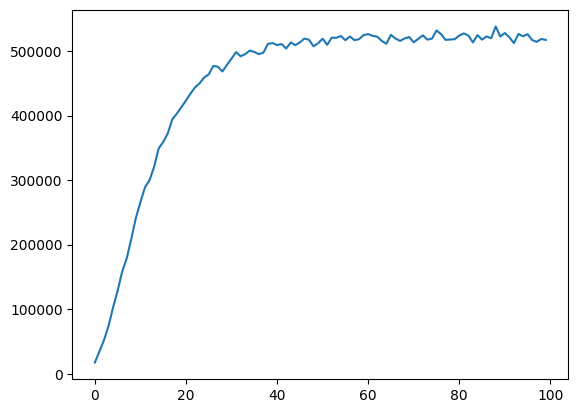

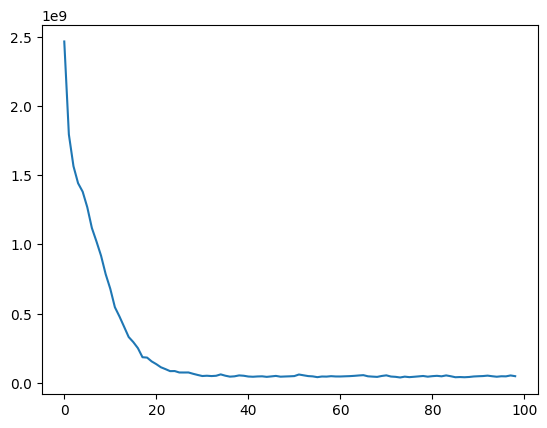

In [21]:
import matplotlib.pyplot as plt

# Value of an initial state across iterations
s0,_ = env.reset()
Vs0 = np.zeros(nb_iter)
for i in range(nb_iter):
    Qs0a = []
    for a in range(nb_actions):
        s0a = np.append(s0,a).reshape(1, -1)
        Qs0a.append(Qfunctions[i].predict(s0a))
    Vs0[i] = np.max(Qs0a)
plt.plot(Vs0)

# Bellman residual
residual = []
for i in range(1,nb_iter):
    residual.append(np.mean((Qfunctions[i].predict(SA)-Qfunctions[i-1].predict(SA))**2))
plt.figure()
plt.plot(residual)

In [22]:
def greedy_action(Q,s,nb_actions):
    Qsa = []
    for a in range(nb_actions):
        sa = np.append(s,a).reshape(1, -1)
        Qsa.append(Q.predict(sa))
    return np.argmax(Qsa)